In [158]:
import math
import random

In [259]:
class Vaule:
    def __init__(self,data, label="", _op="", _prev=set()):
        self.data = data
        self.label = label if label != "" else str(data)
        self._op = _op
        self._prev = _prev
        self.grad = 0
        self._backward = lambda:None

    def __repr__(self):
        return f"Vaule(data={self.data}, op={self._op})"

    def __add__(self,other):
        other = other if isinstance(other, Vaule) else Vaule(other,label=str(other))
        out = Vaule(self.data + other.data, _op="+", _prev=(self,other))
        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backward = _backward
        return out

    def __radd__(self,other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Vaule) else Vaule(other,label=str(other))
        out = Vaule(self.data * other.data, _op="*", _prev=(self,other))
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __pow__(self,other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Vaule(self.data ** other, _op=f"**{other}", _prev=(self,))
        def _backward():
            self.grad += (other*self.data**(other - 1)) * out.grad
        out._backward = _backward
        return out

    def __neg__(self,other):
        return self*(-1)

    def __sub__(self,other):
        return self + (-other)

    def __rsub__(self,other):
        return other + (-self)

    def tanh(self):
        x = self.data
        data = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Vaule(data, label= "tanh(" + self.label + ')', _op="tanh", _prev=(self,))
        def _backward():
            self.grad += (1 - data*data) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        top = []
        # 构建节点集合
        def build_top(v):
            if v not in top:
                for node in v._prev:
                    build_top(node)
                top.append(v)
        build_top(self)
        # 将所有节点梯度清零
        for node in reversed(top):
            node.grad = 0
        # 顶点梯度置为1开始反向传播
        self.grad = 1
        for node in reversed(top):
            node._backward()

In [260]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

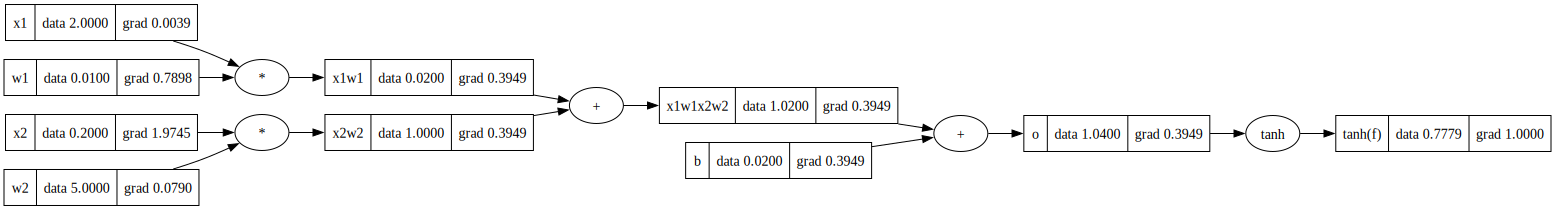

In [261]:
# d = x1*w1 + x2*w2 + b
x1 = Vaule(2.0, label="x1")
x2 = Vaule(0.2, label="x2")
w1 = Vaule(0.01, label="w1")
w2 = Vaule(5.0, label="w2")
b = Vaule(0.02, label="b")

x1w1 = x1 * w1;x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2"

f = x1w1x2w2 + b; f.label = "f"
o = f.tanh() ; f.label = "o"

o.backward()

draw_dot(o)

In [262]:
t1 = Vaule(2.0, label="t1")
t2 = Vaule(2.0, label="t2")

a = t1 + t2
b = t1 * t2
c = a+b
d = a*b
# out = c+d
o =  c+d

o.backward()


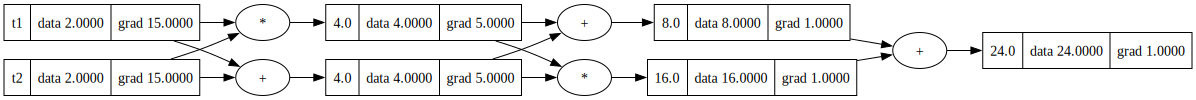

In [263]:
draw_dot(o)

In [264]:
top

[Vaule(t1: data=2.0, op=),
 Vaule(t2: data=2.0, op=),
 Vaule(t1+t2: data=4.0, op=+),
 Vaule(t1*t2: data=4.0, op=*),
 Vaule(t1+t2+t1*t2: data=8.0, op=+),
 Vaule(t1+t2*t1*t2: data=16.0, op=*),
 Vaule(t1+t2+t1*t2+t1+t2*t1*t2: data=24.0, op=+)]

In [265]:
# 单个神经元输入n*1的向量，输出 W*X + b
class Neuron():
    def __init__(self,nin):
        self.w = [Vaule(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Vaule(random.uniform(-1,1))

    def __call__(self, x):
        out = sum([wi*xi for wi,xi in zip(self.w,x)],self.b)
        out = out.tanh()
        return out

    def perameter(self):
        return self.w + [self.b]

# 层,由多个神经元组成一层输入n*1的向量输出nout个 W*Xi + bi
class Layer():
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out if len(out) > 1 else out[0]

    def perameter(self):
        return [p for neu in self.neurons for p in neu.perameter()]

class MLPs():
    def __init__(self,nin,nouts):
        cen = [nin] + nouts
        self.layers = [Layer(cen[i],cen[i+1]) for i in range(len(nouts))]

    def __call__(self,x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out

    def perameter(self):
        return [p for lay in self.layers for p in lay.perameter()]
        

In [266]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [267]:
np.random.seed(1337)
random.seed(1337)

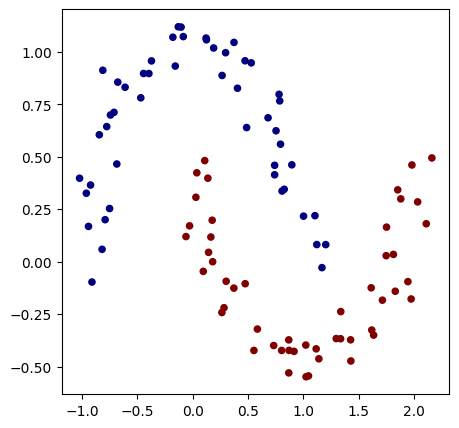

In [268]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [326]:
model = MLPs(2,[16,16,1])

In [334]:
# 需求:输入蓝色坐标输出 -1 , 输入红色坐标输出 1
for k in range(10):
    # 先前传播,计算loss
    loss = sum([(model(xi) +(-yi))**2 for xi,yi in zip(X,y)])
    # 向后传播,计算梯度（先清空原有梯度）
    loss.backward()
    # 根据梯度更新参数
    for p in model.perameter():
        # print(p.data, end= " | ")
        p.data += -0.0005 * p.grad
        # print(p.data, " | ", p.grad)
    print(k,loss.data)

0 6.176316661626593
1 6.026751280984567
2 5.883809341505487
3 5.747085219061898
4 5.616214657633472
5 5.490862401217169
6 5.3707170868887735
7 5.255488546230344
8 5.144905959094036
9 5.038716353740036


In [321]:
loss

Vaule(data=199.99999999159198, op=+)

In [324]:
model.perameter()[7].grad

2.044847623850929e-09

(-1.548639298268643, 1.951360701731357)

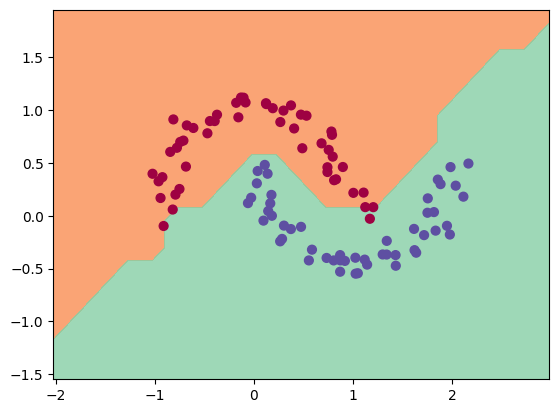

In [335]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Vaule, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

In [339]:
model([0,0.5])

Vaule(data=-0.1144278611609487, op=tanh)